## Notebook for analyzing a tool sandbox run

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pathlib

import pandas as pd
import polars as pl
import seaborn as sns

from tool_sandbox.analysis.analysis import extract_meta_stats, extract_aggregated_stats
from tool_sandbox.analysis.data_loading import (
    extract_scenario_results,
    get_scenario_pretty_print_path,
    load_result_summary,
)

Matplotlib is building the font cache; this may take a moment.


In [2]:
result_summary_path = pathlib.Path(
    # "/Users/tholleis/code/ToolSandbox/data/agent_gemini-1.5-pro-001_user_gpt-4o-2024-05-13_06_14_2024_19_56_00_no_tool_assert/result_summary.json"
    "/Users/andrewrevell/Projects/767/ToolSandbox/data/agent_gpt-4o-mini_user_gpt-4o-mini_06_04_2025_14_39_33_without_domain_all/result_summary.json"
)

results = load_result_summary(result_summary_path)

In [3]:
scenario_df = extract_scenario_results(results)
scenario_df.head(3)

name,categories,traceback,exception_type,milestone_similarity,minefield_similarity,similarity,turn_count,milestone_mapping,minefield_mapping
str,list[str],str,str,f64,f64,f64,i64,struct[6],struct[1]
"""turn_on_location_low_battery_m…","[""STATE_DEPENDENCY"", ""MULTIPLE_TOOL_CALL"", … ""NO_DISTRACTION_TOOLS""]",null,null,0.822698,0.0,0.822698,11,"{[23.0, 1.0],[25.0, 1.0],[26.0, 0.468093],null,null,null}",{null}
"""search_reminder_with_recency_u…","[""INSUFFICIENT_INFORMATION"", ""NO_DISTRACTION_TOOLS""]",null,null,1.0,1.0,0.0,11,"{null,null,null,null,null,null}","{[19.0, 1.0]}"
"""search_reminder_with_creation_…","[""CANONICALIZATION"", ""MULTIPLE_TOOL_CALL"", … ""NO_DISTRACTION_TOOLS""]",null,null,0.933673,0.0,0.933673,15,"{[17.0, 1.0],[21.0, 1.0],[26.0, 0.801018],null,null,null}",{null}


### Extract high-level metadata

In [4]:
meta_stats = extract_meta_stats(scenario_df)
meta_stats

num_scenarios,num_exceptions,total_num_turn_counts,normalized_total_num_turn_counts
i64,i64,i64,f64
129,1,1598,12.387597


In [5]:
exceptions_df = scenario_df.filter(pl.col("exception_type").is_not_null())
exception_count_df = (
    exceptions_df.get_column("exception_type")
    .value_counts()
    .sort(by="count", descending=True)
)
exception_count_df

exception_type,count
str,u32
"""RetryError""",1


### Analyze the different types of exceptions

In [8]:
def create_link_to_pretty_print_file(scenario_name: str):
    pretty_print_path = get_scenario_pretty_print_path(
        result_summary_path=result_summary_path, scenario_name=scenario_name
    )
    return f'<a href="{pretty_print_path}">{scenario_name}</a>'


for exception_type in exception_count_df.get_column("exception_type").to_list():
    df = exceptions_df.filter(pl.col("exception_type") == exception_type)
    pd_df = df.to_pandas()
    desired_column_order = [
        "exception_type",
        "name",
        "traceback",
        "milestone_similarity",
        "minefield_similarity",
        "similarity",
        "turn_count",
        "categories",
        "milestone_mapping",
        "minefield_mapping",
    ]
    pd_df = pd_df[desired_column_order]
    display(
        pd_df.style.format({"name": create_link_to_pretty_print_file})
        .set_caption(f"{exception_type} | {len(df)} / {len(exceptions_df)} exceptions")
        .set_properties(**{"text-align": "left"})
    )

,exception_type,name,traceback,milestone_similarity,minefield_similarity,similarity,turn_count,categories,milestone_mapping,minefield_mapping
0,RetryError,turn_on_cellular_low_battery_mode,"Traceback (most recent call last): File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/tenacity/__init__.py"", line 472, in __call__ result = fn(*args, **kwargs) File ""/Users/andrewrevell/Projects/767/ToolSandbox/tool_sandbox/roles/openai_api_user.py"", line 154, in model_inference return self.openai_client.chat.completions.create( File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/openai/_utils/_utils.py"", line 287, in wrapper return func(*args, **kwargs) File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/openai/resources/chat/completions/completions.py"", line 925, in create return self._post( File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/openai/_base_client.py"", line 1242, in post return cast(ResponseT, self.request(cast_to, opts, stream=stream, stream_cls=stream_cls)) File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/openai/_base_client.py"", line 1037, in request raise self._make_status_error_from_response(err.response) from None openai.BadRequestError: Error code: 400 - {'error': {'message': ""The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766"", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': True, 'detected': True}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}} The above exception was the direct cause of the following exception: Traceback (most recent call last): File ""/Users/andrewrevell/Projects/767/ToolSandbox/tool_sandbox/cli/utils.py"", line 269, in run_scenario result = scenario.play_and_evaluate( File ""/Users/andrewrevell/Projects/767/ToolSandbox/tool_sandbox/common/scenario.py"", line 141, in play_and_evaluate self.play(roles=roles, scenario_name=scenario_name) File ""/Users/andrewrevell/Projects/767/ToolSandbox/tool_sandbox/common/scenario.py"", line 102, in play roles[sandbox_db[""recipient""][-1]].respond() File ""/Users/andrewrevell/Projects/767/ToolSandbox/tool_sandbox/roles/openai_api_user.py"", line 102, in respond response = self.model_inference( File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/tenacity/__init__.py"", line 332, in wrapped_f return self(f, *args, **kw) File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/tenacity/__init__.py"", line 469, in __call__ do = self.iter(retry_state=retry_state) File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/tenacity/__init__.py"", line 370, in iter result = action(retry_state) File ""/Users/andrewrevell/miniforge3/envs/ToolSandbox/lib/python3.9/site-packages/tenacity/__init__.py"", line 413, in exc_check raise retry_exc from fut.exception() tenacity.RetryError: RetryError[]",0.000000,0.000000,0.000000,30,['STATE_DEPENDENCY' 'MULTIPLE_TOOL_CALL' 'SINGLE_USER_TURN' 'NO_DISTRACTION_TOOLS'],"{'0': None, '1': None, '2': None, '3': None, '4': None, '5': None}",{'0': None}


### Extract aggregated statistics per scenario category

In [9]:
agg_stats_df = extract_aggregated_stats(results)
with pl.Config(tbl_rows=-1):
    display(agg_stats_df)

category,similarity,turn_count
str,f64,f64
"""STATE_DEPENDENCY""",0.794976,16.666667
"""MULTIPLE_TOOL_CALL""",0.743066,12.865854
"""SINGLE_USER_TURN""",0.797994,10.945205
"""NO_DISTRACTION_TOOLS""",0.713349,12.387597
"""ALL_CATEGORIES""",0.713349,12.387597
"""INSUFFICIENT_INFORMATION""",0.50925,14.464286
"""CANONICALIZATION""",0.756594,12.423729
"""MULTIPLE_USER_TURN""",0.696768,14.071429
"""SINGLE_TOOL_CALL""",0.885879,7.263158


### Analyze the top/bottom N samples for each category.

In [10]:
scenario_exploded_categories_df = scenario_df.explode("categories")
scenario_exploded_categories_df = scenario_exploded_categories_df.rename(
    {"categories": "category"}
)
scenario_exploded_categories_df.head(3)

name,category,traceback,exception_type,milestone_similarity,minefield_similarity,similarity,turn_count,milestone_mapping,minefield_mapping
str,str,str,str,f64,f64,f64,i64,struct[6],struct[1]
"""turn_on_location_low_battery_m…","""STATE_DEPENDENCY""",null,null,0.822698,0.0,0.822698,11,"{[23.0, 1.0],[25.0, 1.0],[26.0, 0.468093],null,null,null}",{null}
"""turn_on_location_low_battery_m…","""MULTIPLE_TOOL_CALL""",null,null,0.822698,0.0,0.822698,11,"{[23.0, 1.0],[25.0, 1.0],[26.0, 0.468093],null,null,null}",{null}
"""turn_on_location_low_battery_m…","""SINGLE_USER_TURN""",null,null,0.822698,0.0,0.822698,11,"{[23.0, 1.0],[25.0, 1.0],[26.0, 0.468093],null,null,null}",{null}


In [17]:
from enum import auto
from strenum import StrEnum
class ScenarioCategories(StrEnum):
    """Categorical enum describing scenarios. Each scenario can belong to multiple categories"""

    # Scenario that requires a single tool call to complete
    SINGLE_TOOL_CALL = auto()
    # Scenario that requires a multiple tool call to complete
    MULTIPLE_TOOL_CALL = auto()
    # Scenario that requires a single user turn to complete. Note that this doesn't mean
    # there has to be only 1 user turn in the trajectory. If the agent attempted to look for help
    # from the user, there could be multiple user turns in the rollout
    SINGLE_USER_TURN = auto()
    # Scenario that requires a multiple user turn to complete.
    MULTIPLE_USER_TURN = auto()
    # Scenario that involves tools that depends on certain expected world state, and raises error if the expectation
    # is not met
    STATE_DEPENDENCY = auto()
    # Scenario that requires surface form text to be transformed into canonical form
    CANONICALIZATION = auto()
    # Scenario that requires co-reference resolution
    COREFERENCE = auto()
    # Scenario that requires disambiguation between multiple entities / tool choices
    DISAMBIGUATION = auto()
    # Scenario that cannot be completed with the provided tools / user prompts
    INSUFFICIENT_INFORMATION = auto()
    # Tool augmentations
    # All tools provided are necessary to complete the scenario
    NO_DISTRACTION_TOOLS = auto()
    # 3 distraction tools provided in addition to necessary ones
    THREE_DISTRACTION_TOOLS = auto()
    # 10 distraction tools provided in addition to necessary ones
    TEN_DISTRACTION_TOOLS = auto()
    # All tools in the sandbox provided
    ALL_TOOLS_AVAILABLE = auto()
    # Tool names are replaced with less descriptive generic names,
    # E.g. messaging_1 instead of send_message_with_phone_number
    TOOL_NAME_SCRAMBLED = auto()
    # Tool descriptions are removed
    TOOL_DESCRIPTION_SCRAMBLED = auto()
    # Argument description are removed
    ARG_DESCRIPTION_SCRAMBLED = auto()
    # Argument names are replaced with less descriptive generic names,
    # E.g. arg_1 instead of phone_number
    ARG_NAME_SCRAMBLED = auto()
    # Argument type annotations are removed
    ARG_TYPE_SCRAMBLED = auto()

# Let's ignore the augmentation categories for now.
CATEGORIES_WITH_AUGMENTATION = {
    ScenarioCategories.NO_DISTRACTION_TOOLS,
    ScenarioCategories.THREE_DISTRACTION_TOOLS,
    ScenarioCategories.TEN_DISTRACTION_TOOLS,
    ScenarioCategories.ALL_TOOLS_AVAILABLE,
    ScenarioCategories.TOOL_NAME_SCRAMBLED,
    ScenarioCategories.TOOL_DESCRIPTION_SCRAMBLED,
    ScenarioCategories.ARG_DESCRIPTION_SCRAMBLED,
    ScenarioCategories.ARG_NAME_SCRAMBLED,
    ScenarioCategories.ARG_TYPE_SCRAMBLED,
}
CATEGORIES_WITHOUT_AUGMENTATION = {
    category
    for category in ScenarioCategories
    if category not in CATEGORIES_WITH_AUGMENTATION
}

category_strs = {str(c) for c in CATEGORIES_WITHOUT_AUGMENTATION}

# We want to look at scenarios with high/low similarity scores, but not ones where an
# exception occurred.
scenario_exploded_categories_pd_df = scenario_exploded_categories_df.filter(
    pl.col("exception_type").is_null()
).to_pandas()
pd_df = scenario_exploded_categories_pd_df[
    scenario_exploded_categories_pd_df["category"].isin(category_strs)
]

# Show the worst N samples with the lowest similarity for each scenario category.
pd_df = pd_df.sort_values(["category", "similarity"], ascending=[True, True])
N = 3
bottom_n_per_category = pd_df.groupby("category").head(N)
with pd.option_context("display.max_colwidth", None):
    display(
        bottom_n_per_category.style.format({"name": create_link_to_pretty_print_file})
    )

,name,category,traceback,exception_type,milestone_similarity,minefield_similarity,similarity,turn_count,milestone_mapping,minefield_mapping
10,add_reminder_content_and_weekday_delta_and_time_alt,CANONICALIZATION,None,None,0.000000,0.000000,0.000000,7,"{'0': array([15., 0.]), '1': array([15., 0.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
284,find_temperature,CANONICALIZATION,None,None,0.000000,0.000000,0.000000,9,"{'0': array([15., 0.]), '1': array([15., 0.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
314,add_reminder_content_and_weekday_delta_and_time_multiple_user_turn_alt,CANONICALIZATION,None,None,0.000000,0.000000,0.000000,7,"{'0': array([15., 0.]), '1': array([15., 0.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
4,search_reminder_with_recency_upcoming_insufficient_information,INSUFFICIENT_INFORMATION,None,None,1.000000,1.000000,0.000000,11,"{'0': None, '1': None, '2': None, '3': None, '4': None, '5': None}","{'0': array([19., 1.])}"
22,modify_contact_with_message_recency_insufficient_information,INSUFFICIENT_INFORMATION,None,None,1.000000,1.000000,0.000000,13,"{'0': None, '1': None, '2': None, '3': None, '4': None, '5': None}","{'0': array([26., 1.])}"
40,find_current_city_low_battery_mode_insufficient_information,INSUFFICIENT_INFORMATION,None,None,1.000000,1.000000,0.000000,25,"{'0': None, '1': None, '2': None, '3': None, '4': None, '5': None}","{'0': array([28., 1.])}"
11,add_reminder_content_and_weekday_delta_and_time_alt,MULTIPLE_TOOL_CALL,None,None,0.000000,0.000000,0.000000,7,"{'0': array([15., 0.]), '1': array([15., 0.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
80,search_message_with_recency_latest_alt,MULTIPLE_TOOL_CALL,None,None,0.000000,0.000000,0.000000,9,"{'0': array([15., 0.]), '1': array([15., 0.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
105,search_message_with_recency_latest,MULTIPLE_TOOL_CALL,None,None,0.000000,0.000000,0.000000,11,"{'0': array([15., 0.]), '1': array([15., 0.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
316,add_reminder_content_and_weekday_delta_and_time_multiple_user_turn_alt,MULTIPLE_USER_TURN,None,None,0.000000,0.000000,0.000000,7,"{'0': array([15., 0.]), '1': array([15., 0.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}


In [18]:
# Show the best N samples with the highest similarity for each scenario category.
pd_df = pd_df.sort_values(["category", "similarity"], ascending=[True, False])
N = 1
top_n_per_category = pd_df.groupby("category").head(N)
with pd.option_context("display.max_colwidth", None):
    # From https://stackoverflow.com/a/51855581 : we want to make the scenario name a
    # clickable link to the `pretty_print.txt` file.
    display(top_n_per_category.style.format({"name": create_link_to_pretty_print_file}))

,name,category,traceback,exception_type,milestone_similarity,minefield_similarity,similarity,turn_count,milestone_mapping,minefield_mapping
18,add_reminder_content_and_weekday_delta_and_time,CANONICALIZATION,None,None,1.000000,0.000000,1.000000,9,"{'0': array([17., 1.]), '1': array([23., 1.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
42,find_current_location_insufficient_information,INSUFFICIENT_INFORMATION,None,None,1.000000,0.000000,1.000000,11,"{'0': None, '1': None, '2': None, '3': None, '4': None, '5': None}","{'0': array([15., 0.])}"
19,add_reminder_content_and_weekday_delta_and_time,MULTIPLE_TOOL_CALL,None,None,1.000000,0.000000,1.000000,9,"{'0': array([17., 1.]), '1': array([23., 1.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
34,add_reminder_content_and_date_and_time_multiple_user_turn,MULTIPLE_USER_TURN,None,None,1.000000,0.000000,1.000000,7,"{'0': array([19., 1.]), '1': array([21., 1.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
274,convert_currency,SINGLE_TOOL_CALL,None,None,1.000000,0.000000,1.000000,5,"{'0': array([17., 1.]), '1': None, '2': None, '3': None, '4': None, '5': None}",{'0': None}
20,add_reminder_content_and_weekday_delta_and_time,SINGLE_USER_TURN,None,None,1.000000,0.000000,1.000000,9,"{'0': array([17., 1.]), '1': array([23., 1.]), '2': None, '3': None, '4': None, '5': None}",{'0': None}
185,find_stock_symbol_with_company_name_low_battery_mode,STATE_DEPENDENCY,None,None,1.000000,0.000000,1.000000,13,"{'0': array([35., 1.]), '1': array([37., 1.]), '2': array([39., 1.]), '3': array([40., 1.]), '4': None, '5': None}",{'0': None}


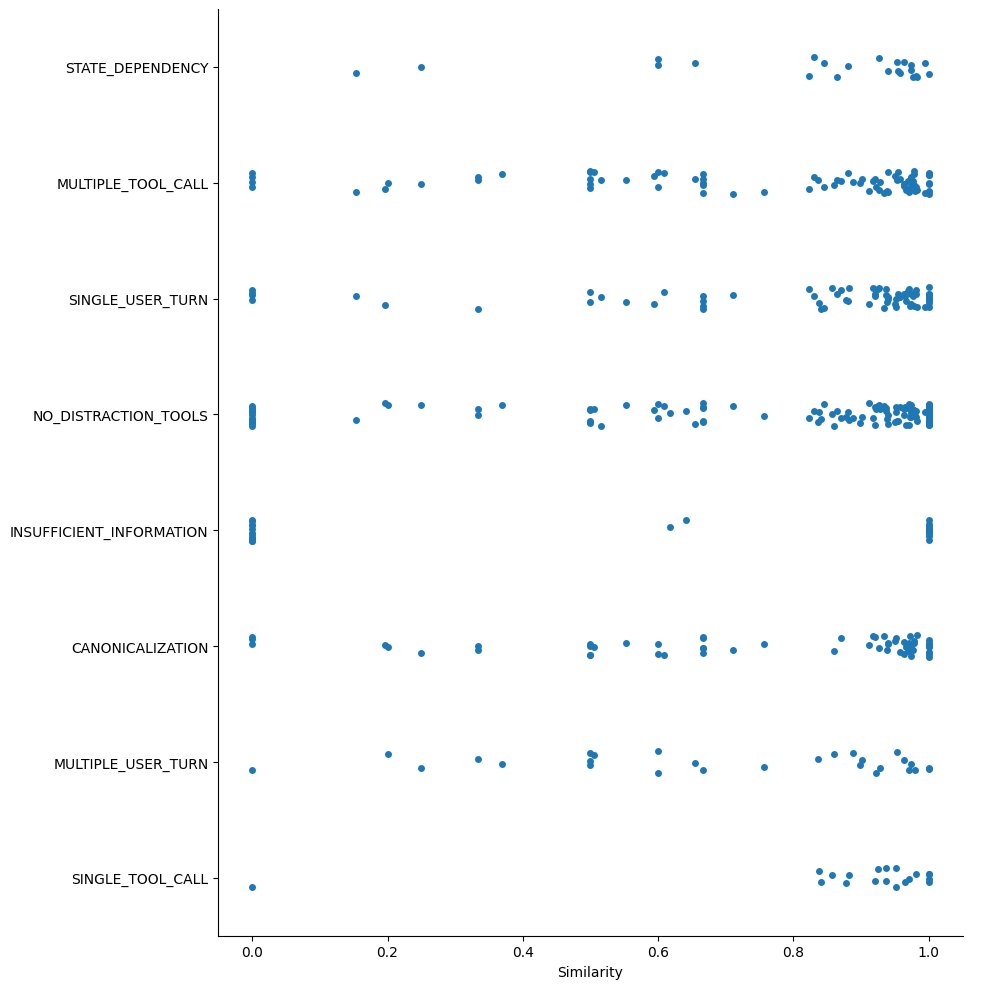

In [19]:
g = sns.catplot(
    data=scenario_exploded_categories_pd_df,
    x="similarity",
    y="category",
    kind="strip",
    height=10,
)
g.set_axis_labels("Similarity", "")